# MULTICLASS CLASSIFIER USING CNN for the SVHN Dataset


In [1]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00


In [2]:
# Necessary imports

import tensorflow as tf
from scipy.io import loadmat
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

###### The datasets (train and test set) needed for this project were downloaded from this link: http://ufldl.stanford.edu/housenumbers/train.tar.gz. They were then unzipped and stored in gdrive for use in this colab notebook.

In [4]:
# Run this to connect the drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load the dataset from drive folder

train = loadmat('/content/gdrive/MyDrive/tf1_project/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/tf1_project/test_32x32.mat')

In [ ]:
# Both train and test sets are dictionaries with X for images and y for labels
print(type(train))
print(type(test))
print()
train_keys = [key for key in train.keys()]
print("Keys of train dataset:\n")
print(train_keys)
print()
test_keys = [key for key in test.keys()]
print("keys of test dataset:\n")
print(test_keys)


<class 'dict'>
<class 'dict'>

Keys of train dataset:

['__header__', '__version__', '__globals__', 'X', 'y']

keys of test dataset:

['__header__', '__version__', '__globals__', 'X', 'y']


Both train and test sets are dictionaries with X for images and y for labels.


###1. Inspection and preprocessing of the dataset

In [3]:
# Extracting train,test images and labels from train. test dictionaries

train_images = train['X']
train_labels = train['y']
test_images = test['X']
test_labels = test['y']

NameError: ignored

In [ ]:
# Inspect shapes
print("Train images dataset shape: ",train_images.shape)
print("Train labels dataset shape: ",train_labels.shape)
print("Test images dataset shape: ",test_images.shape)
print("Test labels dataset shape: ",test_labels.shape)

In [ ]:
train_images_trans = train_images.transpose((3,0,1,2))
train_images_trans.shape

In [ ]:
# try displaying an image with this transposed
sample = train_images_trans[2,:,:,:].reshape((32,32,3))
fig = plt.figure(figsize=(8,8))
plt.imshow((sample).astype(np.uint8))
plt.axis("off")
plt.title(f"Image label: {train_labels[2][0]}")

In [ ]:
new_train_images = train_images.transpose((3,0,1,2))
new_test_images = test_images.transpose((3,0,1,2))
print(new_train_images.shape)
print(new_test_images.shape)

In [ ]:
# Train labels are integers from 1 to 10.
# Change label 10 to label 0
print(train_labels.min())
print(train_labels.max())
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [ ]:
print(train_labels.min())
print(train_labels.max())

Selecting 10 random images and their corresponding labels from train dataset and displaying them in a figurea after the dimension of the train dataset has been changed.

In [ ]:
# Selecting 10 random images and their corresponding labels from train dataset and displaying them in a figure
# display after dimension change

fig = plt.figure(figsize=(8,8))
nrows=5
ncols=2
train_labels_total = train_labels.shape[0]

for j in range(10):
  #add the subplot
  fig.add_subplot(nrows, ncols, j+1)
  # display a random image in the subplot
  random_index = np.random.choice(train_labels_total, size=1, replace=False)
  out = new_train_images[random_index,:,:,:].reshape((32,32,3))
  plt.imshow((out).astype(np.uint8))
  plt.axis("off")
  plt.title(f"Image label: {train_labels[random_index][0][0]}")

Reducing the color dimension from 3 to 1, by taking average across RBG channels.

In [ ]:
def reduce_color_channel(images,labels):
    """
    This function takes mean across all color channels and converts 3 channels to 1. by taking
    colored image dataset and labels in the argument. 
    """
    labels_total = labels.shape[0]
    images_reduce = np.zeros((labels_total, 32,32,1))

    for i in range(labels_total):
      img = images[i,:,:,:]
      img = img.reshape((32,32,3))
      img = np.mean(img,axis=2)
      img = img.reshape((32,32,1))
      images_reduce[i,:,:,:] = img[:,:,:]
    
    return images_reduce

In [ ]:
test_images_reduce = reduce_color_channel(new_test_images, test_labels) #dimension changed earlier now grayscale formed
train_images_reduce = reduce_color_channel(new_train_images, train_labels)
print("Shape of train dataset is ",train_images_reduce.shape)  #color dimension of one retained to feed to CNN
print("Shape of test dataset is", test_images_reduce.shape)

In [ ]:
# display 10 random images after color channel has been reduced to 1

fig = plt.figure(figsize=(8,8))
nrows=5
ncols=2
train_labels_total = train_labels.shape[0]

for j in range(10):
  #add the subplot
  fig.add_subplot(nrows, ncols, j+1)
  # display a random image in the subplot
  random_index = np.random.choice(train_labels_total, size=1, replace=False)
  out = train_images_reduce[random_index,:,:,:].reshape((32,32))
  plt.imshow((out).astype(np.uint8))
  plt.axis("off")
  plt.title(f"Image label: {train_labels[random_index][0][0]}")

### 2. CNN neural network classifier 

In [ ]:
train_images_reduce[1,:,:,:].shape

(32, 32, 1)

Defining three functions each of which return different type of Callback objects.

*   get_checkpoint_best_only: Returns ModelCheckpoint callback object that saves best weights( weights that correspond to lowest loss).

*   get_checkpoint_every_epoch: Returns ModelCheckpoint callback object that saves the weights at the end of every epoch.

*   get_early_stopping: Returns EarlyStopping callback object that stops the training when loss has not improved in the last *specified number of* epochs.




In [ ]:
def get_checkpoint_best_only():
  """
    This function returns ModelCheckpoint object that:
    - saves only the weights that generate the lowest loss
    - saves into the directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint'
    """

  checkpoint_best_path = 'checkpoints_best_only/checkpoint'  #change for your need
  checkpoint_best_only = ModelCheckpoint(filepath=checkpoint_best_path,
                                         save_weight_only=True,
                                         verbose=1,
                                         monitor="loss",
                                         mode="min",
                                         save_best_only=True,
                                         save_freq="epoch")
  
  return checkpoint_best_only

In [ ]:
def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoint_epoch_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'  #change for your need
    checkpoint_every_epoch = ModelCheckpoint(filepath= checkpoint_epoch_path,
                                      save_weights_only= True,
                                      save_freq= "epoch",
                                      verbose=0)
    
    return checkpoint_every_epoch

In [ ]:
def get_early_stopping(p=5):
  """
  This function returns a Earlystopping callback that stops the training when loss
  has not improved in the last 8 epochs.
  """
  early_stopping = EarlyStopping(monitor="loss",
                                 mode="min",
                                 patience=p,
                                 verbose=1)
  
  return early_stopping

In [ ]:
best_only = get_checkpoint_best_only()
every_epoch = get_checkpoint_every_epoch()
early_stopping = get_early_stopping(p=5)

In [ ]:

callbacks = [best_only, every_epoch, early_stopping]


Using Keras Tuner.

In [ ]:
def model_tuner(hp):
    
    model = keras.Sequential([
        
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=8),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [2,3,5]),
        #activation function
        activation='relu',
        input_shape=(32,32,1)),
    
    
    BatchNormalization(),
    Dropout(rate = hp.Choice('drop_rate_1', values=[0.3, 0.4, 0.5])),


    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=8),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [2,3,5]),
        #activation function
        activation='relu'
    ),

    BatchNormalization(),
    Dropout(rate = hp.Choice('drop_rate_2', values=[0.3, 0.4, 0.5])),

    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=10, max_value=100, step=5),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
#initialize the tuner

import keras_tuner

from tensorflow import keras
#creating randomsearch object
tuner = keras_tuner.RandomSearch(model_tuner,
                    objective='val_accuracy',
                    max_trials = 15)


In [ ]:
# make a subset of training images as validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images_reduce, train_labels, test_size=0.25, random_state=42, stratify=train_labels)



In [ ]:

# search best parameter
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 15 Complete [00h 03m 24s]
val_accuracy: 0.8900901079177856

Best val_accuracy So Far: 0.8900901079177856
Total elapsed time: 00h 42m 23s


In [ ]:
model_tuned=tuner.get_best_models(num_models=1)[0]
#summary of best model
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 112)       2912      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 112)      448       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 112)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        44816     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 16)        0

In [ ]:
history = model_tuned.fit(train_images_reduce, train_labels, epochs=20, batch_size=64,
                        verbose=1,
                        validation_split=0.10, callbacks=[callbacks])

Epoch 1/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.9331
Epoch 1: loss improved from inf to 0.23461, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 16s 13ms/step - loss: 0.2346 - accuracy: 0.9331 - val_loss: 0.1924 - val_accuracy: 0.9443
Epoch 2/20
1026/1031 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9378
Epoch 2: loss improved from 0.23461 to 0.21006, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.2101 - accuracy: 0.9378 - val_loss: 0.1879 - val_accuracy: 0.9466
Epoch 3/20
1026/1031 [============================>.] - ETA: 0s - loss: 0.1896 - accuracy: 0.9432
Epoch 3: loss improved from 0.21006 to 0.18952, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1895 - accuracy: 0.9433 - val_loss: 0.2067 - val_accuracy: 0.9408
Epoch 4/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9468
Epoch 4: loss improved from 0.18952 to 0.17486, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1749 - accuracy: 0.9469 - val_loss: 0.2092 - val_accuracy: 0.9373
Epoch 5/20
1030/1031 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9521
Epoch 5: loss improved from 0.17486 to 0.15811, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1581 - accuracy: 0.9521 - val_loss: 0.2744 - val_accuracy: 0.9141
Epoch 6/20
1030/1031 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9544
Epoch 6: loss improved from 0.15811 to 0.14673, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1467 - accuracy: 0.9544 - val_loss: 0.2349 - val_accuracy: 0.9312
Epoch 7/20
1030/1031 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9576
Epoch 7: loss improved from 0.14673 to 0.13750, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 14s 13ms/step - loss: 0.1375 - accuracy: 0.9576 - val_loss: 0.2414 - val_accuracy: 0.9337
Epoch 8/20
1027/1031 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9604
Epoch 8: loss improved from 0.13750 to 0.12578, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1258 - accuracy: 0.9605 - val_loss: 0.2520 - val_accuracy: 0.9272
Epoch 9/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9637
Epoch 9: loss improved from 0.12578 to 0.11714, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1171 - accuracy: 0.9637 - val_loss: 0.2561 - val_accuracy: 0.9287
Epoch 10/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9660
Epoch 10: loss improved from 0.11714 to 0.10866, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.1087 - accuracy: 0.9660 - val_loss: 0.2572 - val_accuracy: 0.9263
Epoch 11/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9684
Epoch 11: loss improved from 0.10866 to 0.09968, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 14s 13ms/step - loss: 0.0997 - accuracy: 0.9684 - val_loss: 0.2607 - val_accuracy: 0.9268
Epoch 12/20
1026/1031 [============================>.] - ETA: 0s - loss: 0.0938 - accuracy: 0.9695
Epoch 12: loss improved from 0.09968 to 0.09378, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.0938 - accuracy: 0.9695 - val_loss: 0.2757 - val_accuracy: 0.9283
Epoch 13/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9724
Epoch 13: loss improved from 0.09378 to 0.08650, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.0865 - accuracy: 0.9723 - val_loss: 0.2775 - val_accuracy: 0.9287
Epoch 14/20
1027/1031 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9743
Epoch 14: loss improved from 0.08650 to 0.08076, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 13s 13ms/step - loss: 0.0808 - accuracy: 0.9744 - val_loss: 0.2964 - val_accuracy: 0.9240
Epoch 15/20
1028/1031 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9753
Epoch 15: loss improved from 0.08076 to 0.07701, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 15s 15ms/step - loss: 0.0770 - accuracy: 0.9754 - val_loss: 0.3003 - val_accuracy: 0.9237
Epoch 16/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9760
Epoch 16: loss improved from 0.07701 to 0.07212, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 14s 14ms/step - loss: 0.0721 - accuracy: 0.9759 - val_loss: 0.2950 - val_accuracy: 0.9283
Epoch 17/20
1027/1031 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9782
Epoch 17: loss improved from 0.07212 to 0.06828, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 14s 13ms/step - loss: 0.0683 - accuracy: 0.9782 - val_loss: 0.3191 - val_accuracy: 0.9173
Epoch 18/20
1030/1031 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9787
Epoch 18: loss improved from 0.06828 to 0.06547, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 14s 14ms/step - loss: 0.0655 - accuracy: 0.9787 - val_loss: 0.3149 - val_accuracy: 0.9212
Epoch 19/20
1027/1031 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9802
Epoch 19: loss improved from 0.06547 to 0.06105, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 15s 14ms/step - loss: 0.0610 - accuracy: 0.9802 - val_loss: 0.3062 - val_accuracy: 0.9260
Epoch 20/20
1029/1031 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9806
Epoch 20: loss improved from 0.06105 to 0.05935, saving model to checkpoints_best_only/checkpoint


1031/1031 [==============================] - 14s 14ms/step - loss: 0.0593 - accuracy: 0.9806 - val_loss: 0.3416 - val_accuracy: 0.9210


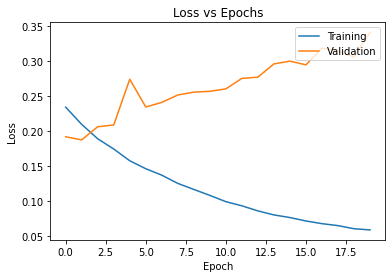

In [ ]:
#Plot loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"], loc='upper right')
plt.show()

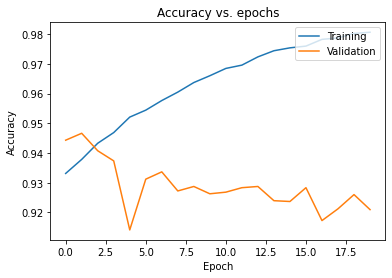

In [ ]:
#Plot accuracy 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Saving the model.


In [ ]:
#file_name = ''
#model_tuned.save('model_final')
tf.keras.models.save_model(model_tuned,filepath='/CNN_SVHN/')  #change the filepath as per your need.

### 3. Getting model predictions

In [ ]:
# Load the best weights into new instance of CNN model

#model_cnn_new = get_cnn_model(input_shape)
#model_cnn_new = model_tuned()
#model_cnn_new.load_weights('checkpoints_best_only/checkpoint')

Loading the model.

In [ ]:
#Load the model from the filepath it was saved in.
model_cnn_new = keras.models.load_model('/CNN_SVHN/')

Randomly selecting 5 test images and and their corresponding labels.
Alongside the image and label, the models predictive distribution is shown as bar chart.

1/1 [==============================] - 0s 204ms/step


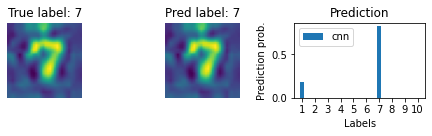

1/1 [==============================] - 0s 35ms/step


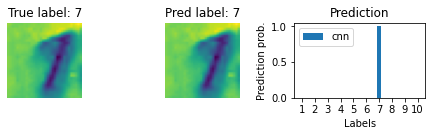

1/1 [==============================] - 0s 40ms/step


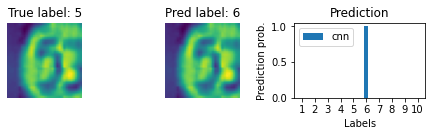

1/1 [==============================] - 0s 51ms/step


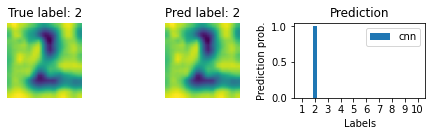

1/1 [==============================] - 0s 37ms/step


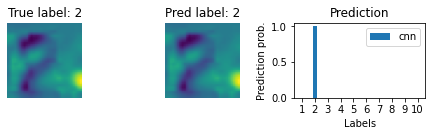

In [ ]:
# Randomly select 5 test images and and their corresponding labels
# Along with the image and label, the models predictive distribution is shown as bar chart

t = 5 #number of test images to display
test_labels_total = test_labels.shape[0]

for i in range(t):

  #randomly select test image
  random_index = np.random.choice(test_labels_total, size=1, replace=False)
  p = random_index
  test_image = test_images_reduce[p,:,:,:]
  
  #get prediction on that image
  pred_cnn = model_cnn_new.predict(test_image) #[1,32,32,1]
  pred_cnn_2 = np.reshape(pred_cnn, (10, ))
  y_cnn = pred_cnn_2.tolist()
  y_cnn_2 = y_cnn[1:]
  z = y_cnn[0]
  y_cnn_2.append(z)
  x_pos = np.arange(1,11)

  #for each image put three subplots(image & actual label), (bar chart of distribution) and (image & predicted label)
  
  fig = plt.figure(figsize=(8,8))
  nrows = t
  ncols = 3

  #plot the actual image and its true label

  j = i*3                      #[0,3,6,9,12]

  fig.add_subplot(nrows, ncols, j+1)
  test = test_image.reshape((32,32))
  plt.imshow(test.astype(np.uint8))
  plt.axis("off")
  true_label = test_labels[p][0][0]
  if true_label == 0:
    true_label = 10
  plt.title(f"True label: {true_label}")
  

  #plot the actual image and its predicted label
  prob_cnn = np.max(pred_cnn_2)
  pred_label = np.argmax(pred_cnn)
  if pred_label == 0:
    pred_label = 10
  
  
  fig.add_subplot(nrows, ncols, j+2)
  test = test_image.reshape((32,32))
  plt.imshow(test.astype(np.uint8))
  plt.axis("off")
  plt.title(f"Pred label: {pred_label}")


  #plot bar chart of prediction distribution
  fig.add_subplot(nrows, ncols, j+3)
  plt.bar(x_pos, y_cnn_2, width=0.3, label='cnn')
  plt.xticks(x_pos)
  plt.legend()
  plt.xlabel('Labels')
  plt.ylabel('Prediction prob.') #prediction probability
  plt.title("Prediction") #prediction distribution
  plt.show()

Getting total prediction accuracy.

In [ ]:
# Getting total prediction accuracy

pred_cnn_all = model_cnn_new.predict(test_images_reduce)  #(26032, 10)

test_labels[test_labels==10] == 0
test_labels_reshaped = test_labels.reshape((26032,))

ind_max = np.argmax(pred_cnn_all, axis=1)  #(26032,0)

total_correct = np.sum(test_labels_reshaped == ind_max)
prediction_accuracy = total_correct * 100 / test_labels_reshaped.size

print(f"Prediction Accuracy is: {prediction_accuracy} %")

814/814 [==============================] - 3s 4ms/step
Prediction Accuracy is: 88.37968653964352 %


In [ ]:
git commit -m "CNN SVHN_wit"